# NeuralProphet Multiple Covariates

## Summary

## Import

In [ ]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import insert, TEXT
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# from prophet.plot import (
#     plot_plotly,
#     plot_components_plotly,
#     add_changepoints_to_plot,
#     plot_yearly,
#     plot_seasonality_plotly,
# )

## Init

In [ ]:
load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

## Helper Functions

In [ ]:
def predict(
    symbol, y_column, country=None, fourier_terms="auto", show_uncertainty=False
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    return predict_generic(
        "fund_etf_daily_em", symbol, y_column, country, fourier_terms, show_uncertainty
    )


def predict_generic(
    table,
    symbol,
    y_column,
    country=None,
    fourier_terms="auto",
    show_uncertainty=False,
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    query = f"SELECT * FROM {table} where symbol = '{symbol}' order by date"
    df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

    df = df.rename(
        columns={
            "date": "ds",
            y_column: "y",
        }
    )

    m = NeuralProphet(
        mcmc_samples=300 if show_uncertainty else 0,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=fourier_terms,
    )  # Prophet object can only be fit once. Instantiate a new object.
    if country is not None:
        m.add_country_holidays(country_name=country)
    m.fit(df)

    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    return (m, df, forecast)

## Trial 1 - append covariates for lagged regressors

#### load data from table

In [ ]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, open, close, high, low, volume, amount, change_rate y 
    FROM index_daily_em_view 
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

In [ ]:
df.describe()

#### load covariate TS

In [ ]:
# 159981 能源化工ETF
# 518880 黄金ETF
# 159985 豆粕ETF
# 511220 城投债ETF
cov_symbol_list = "('518880', '159981', '159985', '511220')"
query = f"""
    SELECT symbol, date DS, change_rate y 
    FROM fund_etf_daily_em 
    where symbol in {cov_symbol_list}
    order by DS asc
"""
cov_df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

In [12]:
# merge and append the 'change_rate' column of cov_df to df, by matching dates
# split cov_df by symbol column
grouped = cov_df.groupby("symbol")
# sub_dfs = {group: data for group, data in grouped}

for group, sdf in grouped:
    sdf = sdf.rename(
        columns={
            "y": f"{group}_y",
        }
    )
    df = pd.merge(df, sdf[["ds", f"{group}_y"]], on='ds', how="left")

df.head()

,ds,open,close,high,low,volume,amount,y,159981_y,159985_y,511220_y,518880_y
0,2020-02-10,8164.40,8265.17,8269.77,8136.36,339588.0,2.830927e+10,0.00,-0.53,1.06,0.09,0.37
1,2020-02-11,8270.06,8301.47,8345.08,8243.03,353603.0,2.742411e+10,0.44,-0.11,-0.21,0.12,-0.26
2,2020-02-12,8294.21,8336.28,8336.28,8266.64,270681.0,2.081825e+10,0.42,-0.43,-0.42,0.12,-0.20
3,2020-02-13,8329.26,8276.91,8368.77,8275.46,294042.0,2.459196e+10,-0.71,-0.11,1.59,-0.02,0.72
4,2020-02-14,8264.24,8312.55,8321.35,8264.24,278215.0,2.315006e+10,0.43,0.32,-0.52,0.08,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...
997,2024-03-18,11041.11,11067.90,11071.31,10982.46,33384763.0,2.599350e+10,0.20,-0.49,-0.88,0.03,-0.80
998,2024-03-19,11053.75,10996.34,11085.45,10993.86,30625525.0,2.370092e+10,-0.65,0.55,0.93,0.03,0.21
999,2024-03-20,10985.25,11021.36,11041.58,10950.17,28570470.0,2.167400e+10,0.23,-0.49,1.11,-0.01,0.21
1000,2024-03-21,11024.70,11024.02,11051.12,10988.42,29306042.0,2.245537e+10,0.02,-0.98,1.73,0.04,2.01


#### transform DF to Prophet schema

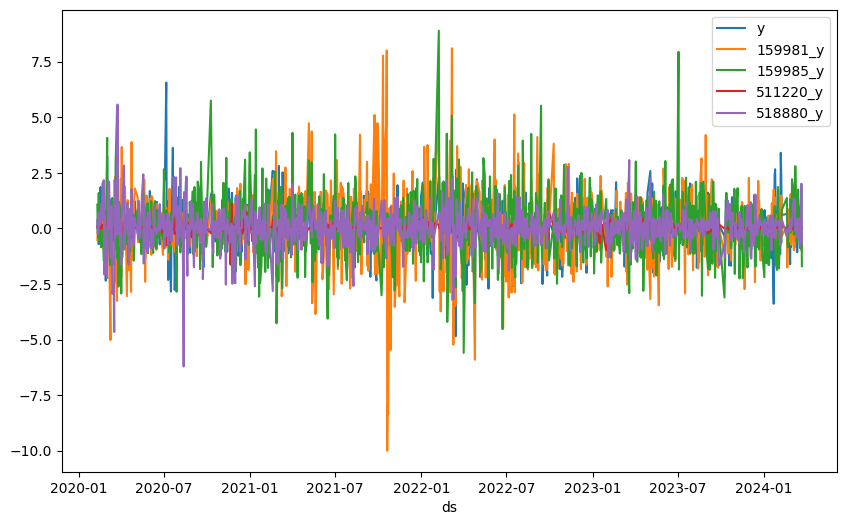

In [13]:
fig = df.plot(
    x="ds", y=["y", "159981_y", "159985_y", "511220_y", "518880_y"], figsize=(10, 6)
)

#### fitting

In [24]:
confidence_level = 0.9

boundaries = round((1 - confidence_level) / 2, 2)
# NeuralProphet only accepts quantiles value in between 0 and 1
quantiles = [boundaries, confidence_level + boundaries]

m = NeuralProphet(
    quantiles=quantiles,
    # Disable change trendpoints
    n_changepoints=32,
    # Smaller values (~0.1-1) allow the model to fit larger seasonal fluctuations,
    # larger values (~1-100) dampen the seasonality. default: None, no regularization
    seasonality_reg=0.8,
    yearly_seasonality=11,  # fourier terms, default 10
    # Disable seasonality components
    weekly_seasonality=False,
    daily_seasonality=False,
    # array of hidden layer dimensions of the AR-Net. Specifies number of hidden layers (number of entries) and layer dimension (list entry)
    ar_layers=[
        64,
        64,
        64,
        64,
        64,
        64,
    ],
    # array of hidden layer dimensions of the Covar-Net.
    # Specifies number of hidden layers (number of entries) and layer dimension (list entry).
    lagged_reg_layers=[
        64,
        64,
        64,
        64,
        64,
        64,
    ],
    # Previous time series steps to include in auto-regression. Aka AR-order
    n_lags=30,
    # Number of steps ahead of prediction time step to forecast.
    # n_forecasts=60,
    # how much sparsity to induce in the AR-coefficients.
    # Large values (~1-100) will limit the number of nonzero coefficients dramatically.
    # Small values (~0.001-1.0) will allow more non-zero coefficients. default: 0 no regularization of coefficients.
    ar_reg=0.05,
    # whether to automatically impute missing dates/values
    # imputation follows a linear method up to 20 missing values, more are filled with trend.
    impute_missing=True,
    # Type of normalization to apply to the time series.
    # - (default) soft scales the minimum value to 0.0 and the 95th quantile to 1.0
    # - standardize zero-centers and divides by the standard deviation
    # normalize="standardize",
)

m.add_lagged_regressor("open", n_lags="auto")
m.add_lagged_regressor("high", n_lags="auto")
m.add_lagged_regressor("low", n_lags="auto")
m.add_lagged_regressor("close", n_lags="auto")
m.add_lagged_regressor("volume", n_lags="auto")
m.add_lagged_regressor("amount", n_lags="auto")
for group, _ in grouped:
    m.add_lagged_regressor(f"{group}_y", n_lags="auto")
# m = m.add_country_holidays("CN")

train_df, test_df = m.split_df(
    df,
    # freq="D",
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((971, 12), (134, 12))

In [25]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    # freq="D",
    progress=None,
    # epochs=500
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,46543.726562,46543.804688,11306.866211,0.000000,0,2.757778e+09,3.029673e+09,9.776595e+08,0.000000
1,4011.062744,4012.454834,953.875854,0.000000,1,1.837282e+04,1.837467e+04,3.419325e+03,0.000000
2,1624.027100,1627.598633,638.390015,0.000000,2,2.337720e+03,2.344308e+03,5.643334e+02,0.000000
3,157.019699,178.154373,330.983887,0.000000,3,1.238979e+03,1.251718e+03,4.067229e+02,0.000000
4,255.442459,274.895813,235.752914,0.000000,4,1.983279e+02,2.255791e+02,2.139897e+02,0.000000
...,...,...,...,...,...,...,...,...,...
115,0.589377,0.862189,0.080394,0.000054,115,7.144193e-01,9.521286e-01,6.462058e-02,0.000069
116,0.589925,0.862490,0.072001,0.000042,116,7.136714e-01,9.495559e-01,5.804158e-02,0.000047
117,0.589224,0.861954,0.050740,0.000044,117,7.071587e-01,9.471360e-01,5.321945e-02,0.000042
118,0.589311,0.861703,0.061328,0.000037,118,7.086210e-01,9.424084e-01,5.222294e-02,0.000040


#### predicting

In [27]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [28]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.007128674685099474, Standard deviation of difference: 0.9534808707025967


#### plotting

In [29]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
# m.highlight_nth_step_ahead_of_each_forecast(None)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [30]:
m.plot_components(
    forecast,
    components=[
        "trend",
        "seasonality",
        "autoregression",
        "uncertainty",
        #   "lagged_regressors"
    ],
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [31]:
m.plot_parameters(
    components=[
        "trend",
        "trend_rate_change",
        "seasonality",
        "autoregression",
        # "lagged_regressors"
    ]
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur